In [1]:
# Generic
import html
import os
from pathlib import Path

# Transformers
from circuitsvis.attention import attention_heads
from circuitsvis.tokens import colored_tokens_multi

# Numerical Computing
import numpy as np
import torch

# Our Code
from maze_transformer.utils.notebook_utils import configure_notebook
from maze_transformer.generation.latticemaze import LatticeMaze, SolvedMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import maze_to_tokens, SPECIAL_TOKENS, HuggingMazeTokenizer
from maze_transformer.evaluation.plot_maze import MazePlot, PathFormat
from maze_transformer.evaluation.eval_model import decode_maze_tokens_to_coords, load_model_with_configs

/Users/luciaq/code/maze-transformer/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup
device = configure_notebook(seed=42, dark_mode=True)
# We won't be training any models
torch.set_grad_enabled(False)


# Get latest model
# this should point towards a directory containing a run. 
# If you don't have any runs, you can create a dataset with `poetry run python scripts/create_dataset.py create ./data/maze 10 --grid_n=4`
# Then train a model with poetry run python scripts/train_model.py ./data/maze/g4-n10`
run_path = Path("../examples/maze/g4-n10")
assert run_path.exists(), f"Run path {run_path.as_posix()} does not exist"
model_path = list(sorted(run_path.glob("**/model.final.pt"), key=os.path.getmtime))[
	-1
].resolve()
model, cfg = load_model_with_configs(model_path)
maze_path = run_path / "maze_tokens.jsonl"

In [3]:
# generate a maze
grid_n: int = cfg.dataset_cfg.grid_n
maze: LatticeMaze = LatticeMazeGenerators.gen_dfs((grid_n, grid_n))
c_start = (0, 0)
c_end = (grid_n - 1, grid_n - 1)

# solve the maze explicitly
path_true = np.array(maze.find_shortest_path(
	c_start = c_start,
	c_end = c_end,
))

# tokenize the maze
tokens = maze_to_tokens(maze, path_true, cfg.dataset_cfg.node_token_map)
path_start_index = tokens.index(SPECIAL_TOKENS["path_start"])
maze_only_tokens = tokens[:path_start_index + 1]

print("maze tokens:", maze_only_tokens)

array = model.to_tokens(" ".join(maze_only_tokens), prepend_bos=False)

maze tokens: ['<ADJLIST_START>', '(3,1)', '<-->', '(3,0)', ';', '(2,0)', '<-->', '(2,1)', ';', '(0,2)', '<-->', '(0,3)', ';', '(3,2)', '<-->', '(3,3)', ';', '(3,0)', '<-->', '(2,0)', ';', '(1,3)', '<-->', '(0,3)', ';', '(1,1)', '<-->', '(1,0)', ';', '(2,3)', '<-->', '(1,3)', ';', '(3,1)', '<-->', '(3,2)', ';', '(1,2)', '<-->', '(1,1)', ';', '(0,1)', '<-->', '(0,2)', ';', '(1,3)', '<-->', '(1,2)', ';', '(2,3)', '<-->', '(2,2)', ';', '(0,0)', '<-->', '(1,0)', ';', '(2,2)', '<-->', '(3,2)', ';', '<ADJLIST_END>', '<ORIGIN_START>', '(0,0)', '<ORIGIN_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<PATH_START>']


In [4]:
# have the model predict some tokens
context_str: list[str] = maze_only_tokens

# escape for html
context_str = [ html.escape(t) for t in context_str ]

array_tensor = torch.tensor(array).long().to(device)
with torch.no_grad():
	logits, cache = model.run_with_cache(array_tensor)

attentions = [w for k, w in cache.items() if 'hook_pattern' in k]
print(f"{logits.shape = }\n{len(attentions) = }\n{[x.shape for x in attentions] = }")

# `output.attentions` is a tuple of tensors, where each element of the tuple corresponds to a layer. 
#  The tensor has dimensions (1, n_heads, n_positions, n_positions)


logits.shape = torch.Size([1, 69, 27])
len(attentions) = 4
[x.shape for x in attentions] = [torch.Size([1, 2, 69, 69]), torch.Size([1, 2, 69, 69]), torch.Size([1, 2, 69, 69]), torch.Size([1, 2, 69, 69])]


/var/folders/y0/wnzcrr3s6ml__xf1k_flfl3h0000gn/T/ipykernel_30289/1285469696.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [5]:
n_layers: int = len(attentions)
n_heads: int = attentions[0].shape[1]
n_tokens: int = attentions[0].shape[2]
attention_to_plot = torch.concatenate(attentions, dim=0).reshape(-1, n_tokens, n_tokens)
attention_head_names = [f"Layer {i} Head {j}" for i in range(n_layers) for j in range(n_heads)]
attention_heads(attention_to_plot,maze_only_tokens, attention_head_names)

In [6]:
#! ALEX note - there used to be a np.power(head_np, 1/4) here, not sure what that's about?
FROM_TOKEN = -1 # Look at attention from this token position to the rest of the sequence
attentions_from_token = torch.concatenate([w[0, :, FROM_TOKEN, :] for w in attentions], dim=0)
colored_tokens_multi(context_str, attentions_from_token.T, labels=attention_head_names)

FAIL: Sampled a path - No coordinate token found before EOS
SUCCESS: Model predicted the path:
['<-->', '(3,3)', '(0,2)', '<PATH_START>', '(3,0)', '(3,3)', '(1,2)', '(0,1)', ';', '<TARGET_START>', '<PATH_START>', '(3,2)', '<-->', '<ORIGIN_START>', '(3,0)', '(2,3)', '<PATH_END>']


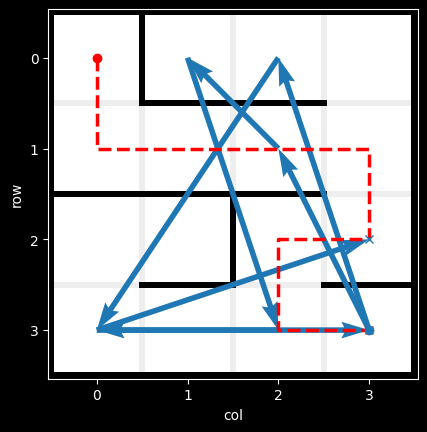

In [7]:
def prediction_contained_a_coordinate_token(tokens: list[str], tokenizer: HuggingMazeTokenizer) -> bool:
	"""Check if the prediction contains a coordinate token"""
	for t in tokens:
		if t not in list(tokenizer.special_tokens_map.values()) + tokenizer.additional_special_tokens:
			return True
	print("FAIL: Sampled a path - No coordinate token found before EOS")
	return False

predicted_tokens = []
while not prediction_contained_a_coordinate_token(predicted_tokens, model.tokenizer):
	predictions = model.generate(array_tensor, max_new_tokens=50, stop_at_eos=True, verbose=False)
	predicted_tokens = model.to_str_tokens(predictions)[len(maze_only_tokens):]
print("SUCCESS: Model predicted the path:")
print(predicted_tokens)

path_predicted: list[tuple[int,int]] = decode_maze_tokens_to_coords(
	predicted_tokens,
	mazedata_cfg = cfg.dataset_cfg, 
	when_noncoord = "skip",
)

# plot the maze and both solutions
# for label, fmt, color, path in paths
MazePlot(maze).add_true_path(path_true).add_predicted_path(path_predicted).show()